In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

In [4]:
from matplotlib import font_manager, rc
import matplotlib
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc("font", family = font_name)

In [2]:
df = pd.read_csv("./Study/Dacon_1206/data/train.csv")
test = pd.read_csv("./Study/Dacon_1206/data/test.csv")

In [3]:
test.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [5]:
df['사고시간'] = df['사고일시'].str.split(" ").str.get(1)
df['사고일시'] = df['사고일시'].str.split(" ").str.get(0)
df['사고일시'] = pd.to_datetime(df['사고일시'])
df['분기'] = df['사고일시'].dt.quarter.astype('object')
df.drop('사고일시', axis = 1, inplace = True)

test['사고시간'] = test['사고일시'].str.split(" ").str.get(1)
test['사고일시'] = test['사고일시'].str.split(" ").str.get(0)
test['사고일시'] = pd.to_datetime(test['사고일시'])
test['분기'] = test['사고일시'].dt.quarter.astype('object')
test.drop('사고일시', axis = 1, inplace = True)

In [6]:
df['군구'] = df['시군구'].str.split(" ").str.get(1)
df['동'] = df['시군구'].str.split(" ").str.get(2)
df.drop('시군구', axis = 1, inplace = True)

test['군구'] = test['시군구'].str.split(" ").str.get(1)
test['동'] = test['시군구'].str.split(" ").str.get(2)
test.drop('시군구', axis = 1, inplace = True)

In [7]:
df['노면상태'].replace({
    '기타':0, '침수':0, '적설':0, '건조':1, '젖음/습기':2, '서리/결빙':3
}, inplace = True)

test['노면상태'].replace({
    '기타':0, '침수':0, '적설':0, '건조':1, '젖음/습기':2, '서리/결빙':3
}, inplace = True)

In [8]:
df['사고유형'].replace({
    '차량단독':1, '차대차':0, '차대사람':2
}, inplace = True)

test['사고유형'].replace({
    '차량단독':1, '차대차':0, '차대사람':2
}, inplace = True)

In [9]:
data1 = pd.read_csv('./Study/Dacon_1206/data/external_open/대구 CCTV 정보.csv', encoding='ANSI')
data2 = pd.read_csv('./Study/Dacon_1206/data/external_open/대구 보안등 정보.csv', encoding='ANSI', low_memory = False)
data3 = pd.read_csv('./Study/Dacon_1206/data/external_open/대구 어린이 보호 구역 정보.csv', encoding='ANSI')
data4 = pd.read_csv('./Study/Dacon_1206/data/external_open/대구 주차장 정보.csv', encoding='ANSI')

In [10]:
cond1 = data1['단속구분'] == 1
cond2 = data1['단속구분'] == 2
data1_1 = data1[cond1|cond2]

In [11]:
spd = data1_1.groupby('시군구명').mean(numeric_only = True)['제한속도']

In [12]:
df['단속카메라수'] = df['군구'].replace(data1_1['시군구명'].value_counts())
test['단속카메라수'] = test['군구'].replace(data1_1['시군구명'].value_counts())

In [13]:
df['평균제한속도'] = df['군구'].replace(spd)
test['평균제한속도'] = test['군구'].replace(spd)

In [14]:
test.head()

,ID,요일,기상상태,도로형태,노면상태,사고유형,사고시간,분기,군구,동,단속카메라수,평균제한속도
0,ACCIDENT_39609,토요일,맑음,교차로 - 교차로안,1,2,01,1,수성구,상동,95,48.631579
1,ACCIDENT_39610,토요일,맑음,단일로 - 기타,1,2,01,1,수성구,지산동,95,48.631579
2,ACCIDENT_39611,토요일,맑음,교차로 - 교차로안,1,0,04,1,수성구,수성동2가,95,48.631579
3,ACCIDENT_39612,토요일,맑음,단일로 - 기타,1,0,04,1,수성구,신매동,95,48.631579
4,ACCIDENT_39613,토요일,맑음,교차로 - 교차로안,1,0,06,1,달서구,감삼동,140,43.785714


In [15]:
df.head()

,ID,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,중상자수,경상자수,부상자수,ECLO,사고시간,분기,군구,동,단속카메라수,평균제한속도
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,1,2,길가장자리구역통행중,안전운전불이행,승용,여,...,1,0,0,5,00,1,중구,대신동,26,50.000000
1,ACCIDENT_00001,화요일,흐림,단일로 - 기타,1,2,보도통행중,기타,승용,남,...,0,1,0,3,00,1,달서구,감삼동,140,43.785714
2,ACCIDENT_00002,화요일,맑음,단일로 - 기타,1,2,차도통행중,안전운전불이행,승용,남,...,0,1,0,3,01,1,수성구,두산동,95,48.631579
3,ACCIDENT_00003,화요일,맑음,단일로 - 기타,1,0,추돌,안전운전불이행,승용,남,...,1,0,0,5,02,1,북구,복현동,123,45.040650
4,ACCIDENT_00004,화요일,맑음,단일로 - 기타,1,0,추돌,안전운전불이행,승용,남,...,0,1,0,3,04,1,동구,신암동,78,49.743590


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   도로형태         39609 non-null  object 
 4   노면상태         39609 non-null  int64  
 5   사고유형         39609 non-null  int64  
 6   사고유형 - 세부분류  39609 non-null  object 
 7   법규위반         39609 non-null  object 
 8   가해운전자 차종     39609 non-null  object 
 9   가해운전자 성별     39609 non-null  object 
 10  가해운전자 연령     39609 non-null  object 
 11  가해운전자 상해정도   39609 non-null  object 
 12  피해운전자 차종     38618 non-null  object 
 13  피해운전자 성별     38618 non-null  object 
 14  피해운전자 연령     38618 non-null  object 
 15  피해운전자 상해정도   38618 non-null  object 
 16  사망자수         39609 non-null  int64  
 17  중상자수         39609 non-null  int64  
 18  경상자수         39609 non-null  int64  
 19  부상자수

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      10963 non-null  object 
 1   요일      10963 non-null  object 
 2   기상상태    10963 non-null  object 
 3   도로형태    10963 non-null  object 
 4   노면상태    10963 non-null  int64  
 5   사고유형    10963 non-null  int64  
 6   사고시간    10963 non-null  object 
 7   분기      10963 non-null  object 
 8   군구      10963 non-null  object 
 9   동       10963 non-null  object 
 10  단속카메라수  10963 non-null  int64  
 11  평균제한속도  10963 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 1.0+ MB


In [18]:
df.drop('동', axis = 1, inplace = True)
test.drop('동', axis = 1, inplace = True)

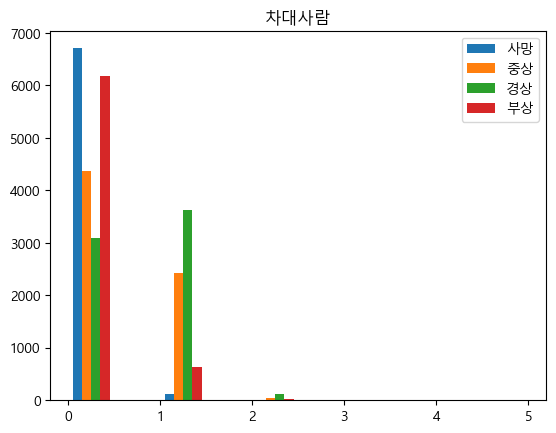

In [19]:
plt.title("차대사람")
plt.hist([df[df['사고유형'] == 2]['사망자수'], df[df['사고유형'] == 2]['중상자수'], df[df['사고유형'] == 2]['경상자수'], df[df['사고유형'] == 2]['부상자수']], label = ['사망', '중상', '경상', '부상'])
plt.legend()
plt.show()

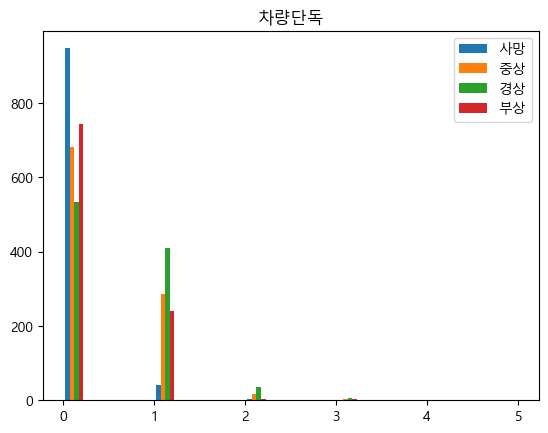

In [20]:
plt.title("차량단독")
plt.hist([df[df['사고유형'] == 1]['사망자수'], df[df['사고유형'] == 1]['중상자수'], df[df['사고유형'] == 1]['경상자수'], df[df['사고유형'] == 1]['부상자수']], label = ['사망', '중상', '경상', '부상'], bins = 20, range = (0, 5))
plt.legend()
plt.show()

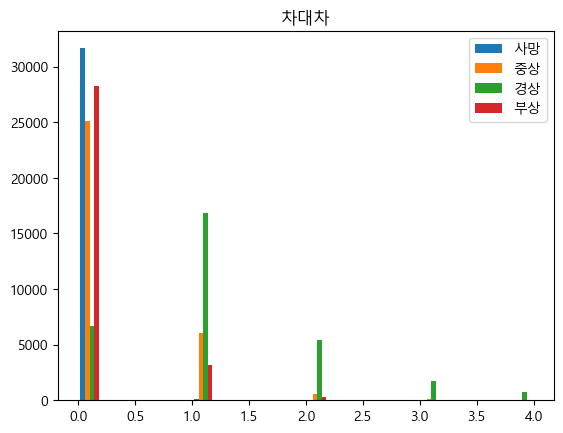

In [21]:
plt.title("차대차")
plt.hist([df[df['사고유형'] == 0]['사망자수'], df[df['사고유형'] == 0]['중상자수'], df[df['사고유형'] == 0]['경상자수'], df[df['사고유형'] == 0]['부상자수']], label = ['사망', '중상', '경상', '부상'], bins = 20, range = (0, 4))
plt.legend()
plt.show()

In [22]:
df.groupby('사고유형').mean(numeric_only = True)[['사망자수', '중상자수', '경상자수', '부상자수']]

,사망자수,중상자수,경상자수,부상자수
사고유형,,,,
0,0.004310,0.237848,1.194526,0.128677
1,0.046418,0.336024,0.533804,0.260343
2,0.018294,0.365725,0.569003,0.099078


- 0 : 차대차, 1 : 차량단독, 2 : 차대사람

In [23]:
df.groupby('평균제한속도').mean(numeric_only = True)[['사망자수', '중상자수', '경상자수', '부상자수']]

,사망자수,중상자수,경상자수,부상자수
평균제한속도,,,,
43.785714,0.004752,0.239308,1.089576,0.105652
44.500000,0.005471,0.243845,1.073857,0.128175
45.040650,0.008271,0.283609,1.021504,0.122406
47.272727,0.007439,0.281259,1.048641,0.149070
47.524752,0.020961,0.316950,1.061077,0.094687
48.631579,0.004324,0.250932,1.104816,0.114955
49.743590,0.010110,0.267366,1.108219,0.126943
50.000000,0.011369,0.247385,0.971805,0.275580


In [24]:
df.groupby('단속카메라수').mean(numeric_only = True)[['사망자수', '중상자수', '경상자수', '부상자수']]

,사망자수,중상자수,경상자수,부상자수
단속카메라수,,,,
26,0.011369,0.247385,0.971805,0.275580
40,0.005471,0.243845,1.073857,0.128175
55,0.007439,0.281259,1.048641,0.149070
78,0.010110,0.267366,1.108219,0.126943
95,0.004324,0.250932,1.104816,0.114955
101,0.020961,0.316950,1.061077,0.094687
123,0.008271,0.283609,1.021504,0.122406
140,0.004752,0.239308,1.089576,0.105652


In [25]:
df.describe()

,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,단속카메라수,평균제한속도
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,1.077912,0.370042,0.007776,0.262365,1.070085,0.126865,4.726704,98.151405,46.580373
std,0.276292,0.760361,0.090109,0.500845,0.992034,0.394670,3.207206,35.634551,2.333149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,26.000000,43.785714
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,78.000000,44.500000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,95.000000,47.272727
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,123.000000,48.631579
max,3.000000,2.000000,2.000000,6.000000,22.000000,10.000000,74.000000,140.000000,50.000000


In [26]:
df.describe(include = 'O')

,ID,요일,기상상태,도로형태,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사고시간,분기,군구
count,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,38618,38618,38618,38618,39609,39609,39609
unique,39609,7,6,11,14,11,12,3,89,6,13,3,97,6,24,4,8
top,ACCIDENT_00000,금요일,맑음,단일로 - 기타,측면충돌,안전운전불이행,승용,남,60세,상해없음,승용,남,59세,경상,18,4,달서구
freq,1,6179,36181,19485,17104,21876,26705,29052,1031,29309,20315,27505,867,25034,3398,10505,9891


In [27]:
test_id = test.pop('ID')
df.drop('ID', axis = 1, inplace = True)

In [28]:
col_n = test.select_dtypes(['int64', 'float64']).columns
col_o = test.select_dtypes('object').columns

In [29]:
Y = df[['사망자수', '중상자수', '경상자수', '부상자수']]

In [30]:
df_n = df[col_n]
df_o = df[col_o]

test_n = test[col_n]
test_o = test[col_o]

In [31]:
rs = RobustScaler()
df_n = pd.DataFrame(rs.fit_transform(df_n), columns = col_n)
test_n = pd.DataFrame(rs.transform(test_n), columns = col_n)

In [32]:
obj = pd.concat([df_o, test_o], axis = 0)

obj = pd.get_dummies(obj)

df_o = obj.iloc[:len(df_o)]
test_o = obj.iloc[len(df_o):]

C:\Users\yjg10\AppData\Local\Temp\ipykernel_26060\189694091.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  obj = pd.get_dummies(obj)


In [33]:
df2 = pd.concat([df_n, df_o], axis = 1)
test2 = pd.concat([test_n, test_o], axis = 1)

In [34]:
df2.shape, test2.shape

((39609, 64), (10963, 64))

In [35]:
y1, y2, y3, y4 = Y.iloc[:, 0], Y.iloc[:, 1], Y.iloc[:, 2], Y.iloc[:, 3]

In [108]:
class ml():
    train_x = None
    train_y = None
    
    def __init__ (self, A, B):
        self.train_x = A
        self.train_y = B

    def split(self, size):
        self.X_tr, self.X_val, self.y_tr, self.y_val = train_test_split(self.train_x, self.train_y, test_size = size, random_state = 0)

    def model_fit(self, md):
        self.model = md
        self.model.fit(self.X_tr, self.y_tr)
    
    def model_predict(self, test):
        self.pred = self.model.predict(self.X_val)
        print(mean_squared_log_error(self.y_val, self.pred))
        self.final = self.model.predict(test)
        return self.final

In [45]:
rf = RandomForestRegressor(max_depth = 15, n_estimators = 500)

In [46]:
M1 = ml(df2, y1)
M1.split(0.2)
M1.model_fit(rf)
pred1 = M1.model_predict(test2)

0.014910449544113278


In [47]:
M2 = ml(df2, y2)
M2.split(0.2)
M2.model_fit(rf)
pred2 = M2.model_predict(test2)

0.38424112951021183


In [48]:
M3 = ml(df2, y3)
M3.split(0.2)
M3.model_fit(rf)
pred3 = M3.model_predict(test2)

0.6669389724870438


In [49]:
M4 = ml(df2, y4)
M4.split(0.2)
M4.model_fit(rf)
pred4 = M4.model_predict(test2)

0.22542340667997424


In [50]:
eclo = pred1*10 + pred2*5 + pred3*3 + pred4

In [51]:
final = pd.DataFrame({
    'ID':test_id,'ECLO':eclo 
})

In [53]:
final.to_csv("submission_1st.csv", index = False)

In [74]:
dl = keras.Sequential()
dl.add(keras.layers.Dense(100, activation = 'relu', input_shape = (df2.shape[1], )))
dl.add(keras.layers.Dropout(0.2))
dl.add(keras.layers.Dense(50, activation = 'relu'))
dl.add(keras.layers.Dropout(0.1))
dl.add(keras.layers.Dense(4))

In [75]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [76]:
dl.compile(optimizer = 'adam', loss = 'mse', metrics =  'mean_absolute_error')

In [77]:
x_train, x_val, y_train, y_val = train_test_split(df2, Y, test_size = 0.2, random_state = 0)

In [78]:
history = dl.fit(x_train, y_train, epochs = 1000, batch_size = 64,
                 validation_data = (x_val, y_val), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3583 - mean_absolute_error: 0.3454 - val_loss: 0.3473 - val_mean_absolute_error: 0.3134
Epoch 2/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3347 - mean_absolute_error: 0.3268 - val_loss: 0.3453 - val_mean_absolute_error: 0.3271
Epoch 3/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3321 - mean_absolute_error: 0.3247 - val_loss: 0.3447 - val_mean_absolute_error: 0.3183
Epoch 4/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3303 - mean_absolute_error: 0.3242 - val_loss: 0.3453 - val_mean_absolute_error: 0.3193
Epoch 5/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3280 - mean_absolute_error: 0.3233 - val_loss: 0.3452 - val_mean_absolute_error: 0.3209
Epoch 6/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3268 - mean_absolute_error: 0.3226 - val_loss: 0.3474 - val_mean_absolute_error: 0.3195
Epoc

In [79]:
dl_pred = dl.predict(test2)

343/343 [==============================] - 0s 502us/step


In [80]:
dl_pred

array([[ 1.94159746e-02,  3.30515444e-01,  5.27181983e-01,
         8.69556069e-02],
       [ 2.65967511e-02,  3.29451710e-01,  4.89604712e-01,
         9.27097499e-02],
       [ 1.15484977e-02,  3.02191556e-01,  1.12399423e+00,
         1.15736365e-01],
       ...,
       [-5.30865975e-04,  1.70771211e-01,  1.29950976e+00,
         9.53219533e-02],
       [-2.70208251e-03,  1.68983668e-01,  1.30559039e+00,
         1.06628656e-01],
       [ 3.28556262e-03,  2.23276824e-01,  1.30601013e+00,
         1.18919820e-01]], dtype=float32)

In [82]:
pd.DataFrame(dl_pred)

,0,1,2,3
0,0.019416,0.330515,0.527182,0.086956
1,0.026597,0.329452,0.489605,0.092710
2,0.011548,0.302192,1.123994,0.115736
3,0.014203,0.239536,1.120964,0.130067
4,0.009706,0.264565,0.986840,0.111743
...,...,...,...,...
10958,0.001707,0.157745,1.540761,0.148130
10959,-0.002626,0.192030,1.243730,0.114600
10960,-0.000531,0.170771,1.299510,0.095322
10961,-0.002702,0.168984,1.305590,0.106629


In [96]:
dl2 = keras.Sequential()

In [97]:
dl2.add(keras.layers.Conv1D(filters = 64, kernel_size = 2, activation = 'relu', input_shape = (df2.shape[1], 1)))
dl2.add(keras.layers.MaxPool1D(pool_size = 3))
dl2.add(keras.layers.Flatten())
dl2.add(keras.layers.Dense(10, activation = 'relu'))
dl2.add(keras.layers.Dropout(0.2))
dl2.add(keras.layers.Dense(4))

In [98]:
dl2.compile(optimizer = 'adam', loss = 'mse', metrics = 'mean_absolute_error')

In [99]:
history = dl2.fit(x_train, y_train, epochs = 1000, batch_size = 64,
                 validation_data = (x_val, y_val), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3720 - mean_absolute_error: 0.3621 - val_loss: 0.3526 - val_mean_absolute_error: 0.3206
Epoch 2/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3440 - mean_absolute_error: 0.3382 - val_loss: 0.3475 - val_mean_absolute_error: 0.3209
Epoch 3/1000
496/496 [==============================] - 1s 2ms/step - loss: 0.3386 - mean_absolute_error: 0.3311 - val_loss: 0.3473 - val_mean_absolute_error: 0.3208
Epoch 4/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3360 - mean_absolute_error: 0.3274 - val_loss: 0.3467 - val_mean_absolute_error: 0.3255
Epoch 5/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3343 - mean_absolute_error: 0.3259 - val_loss: 0.3462 - val_mean_absolute_error: 0.3262
Epoch 6/1000
496/496 [==============================] - 1s 1ms/step - loss: 0.3330 - mean_absolute_error: 0.3249 - val_loss: 0.3464 - val_mean_absolute_error: 0.3204
Epoc

In [100]:
dl2.predict(test2)

343/343 [==============================] - 0s 611us/step


array([[0.02046241, 0.36321875, 0.6133327 , 0.0999551 ],
       [0.01990713, 0.35950407, 0.6239142 , 0.10152768],
       [0.01392303, 0.32063243, 1.248079  , 0.11257712],
       ...,
       [0.00612121, 0.22473639, 1.339639  , 0.11446098],
       [0.00606269, 0.22587332, 1.3638086 , 0.12143036],
       [0.00869437, 0.24955507, 1.4056875 , 0.10908867]], dtype=float32)

In [101]:
final2 = pd.DataFrame(dl2.predict(test2))

343/343 [==============================] - 0s 604us/step


In [102]:
final2

,0,1,2,3
0,0.020462,0.363219,0.613333,0.099955
1,0.019907,0.359504,0.623914,0.101528
2,0.013923,0.320632,1.248079,0.112577
3,0.011749,0.287364,1.323334,0.105120
4,0.011368,0.296034,1.045540,0.107665
...,...,...,...,...
10958,0.003190,0.171098,1.536044,0.107252
10959,0.005266,0.213005,1.345195,0.115812
10960,0.006121,0.224736,1.339639,0.114461
10961,0.006063,0.225873,1.363809,0.121430


In [103]:
eclo2 = final2[0]*10 + final2[1]*5 + final2[2]*3 + final2[3]

In [104]:
eclo2

0        3.960671
1        3.969862
2        5.599206
3        5.629427
4        4.838135
           ...   
10958    5.602774
10959    5.269081
10960    5.318272
10961    5.402850
10962    5.660871
Length: 10963, dtype: float32

In [105]:
final2_submit = pd.DataFrame({
    'ID':test_id,'ECLO':eclo2 
})

In [106]:
final2_submit.to_csv('submission_3th.csv', index = False)